# imports

In [41]:
!pip install einops
!pip install zarr
!pip install xarray[io]
!pip install -Uqq ipdb
from numpy import save, load
from pathlib import Path
import dask.array as da
import warnings
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import ipdb
from tqdm import tqdm
import torch
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, roc_auc_score, average_precision_score
import numpy as np
from torch import nn
import math
from torch.optim.optimizer import Optimizer
import pandas as pd
from einops import rearrange
from torch.nn import functional as F
import xarray as xr
from torch.utils.data import Dataset, DataLoader
import zarr
import sys


In [2]:
%pdb off

Automatic pdb calling has been turned OFF


# support classes for model

In [3]:
#from Models.AbsolutePositionalEncoding import tAPE, AbsolutePositionalEncoding, LearnablePositionalEncoding
#from Models.Attention import Attention, Attention_Rel_Scl, Attention_Rel_Vec

def get_optimizer(name):

    if name == "Adam":
        return torch.optim.Adam
    elif name == "RAdam":
        return RAdam

def get_loss_module():
    return NoFussCrossEntropyLoss(reduction='none')  # outputs loss for each batch sample
class WeightedBCELoss(nn.Module):
    def __init__(self, pos_weight):
        super(WeightedBCELoss, self).__init__()
        self.pos_weight = pos_weight

    def forward(self, inputs, targets):
        # Compute the weighted BCE loss
        loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets, pos_weight=self.pos_weight)
        return loss

class Permute(nn.Module):
    def forward(self, x):
        return x.permute(1, 0, 2)

# from https://github.com/LiyuanLucasLiu/RAdam/blob/master/radam/radam.py
class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, degenerated_to_sgd=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        if isinstance(params, (list, tuple)) and len(params) > 0 and isinstance(params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0] or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay,
                        buffer=[[None, None, None] for _ in range(10)])
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                state['step'] += 1
                buffered = group['buffer'][int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt(
                            (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (
                                        N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(exp_avg, denom, value=-step_size * group['lr'])
                    p.data.copy_(p_data_fp32)
                elif step_size > 0:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    p_data_fp32.add_(exp_avg, alpha=-step_size * group['lr'])
                    p.data.copy_(p_data_fp32)

        return loss

class tAPE(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens
        in the sequence. The positional encodings have the same dimension as
        the embeddings, so that the two can be summed. Here, we use sine and cosine
        functions of different frequencies.
    .. math::
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=1024).
    """

    def __init__(self, d_model, dropout=0.1, max_len=1024, scale_factor=1.0):
        super(tAPE, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)  # positional encoding
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin((position * div_term)*(d_model/max_len))
        pe[:, 1::2] = torch.cos((position * div_term)*(d_model/max_len))
        pe = scale_factor * pe.unsqueeze(0)
        self.register_buffer('pe', pe)  # this stores the variable in the state_dict (used for non-trainable variables)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        """
        x = x + self.pe
        return self.dropout(x)

class Attention_Rel_Scl(nn.Module):
    def __init__(self, emb_size, num_heads, seq_len, dropout):
        super().__init__()
        self.seq_len = seq_len
        self.num_heads = num_heads
        self.scale = emb_size ** -0.5
        # self.to_qkv = nn.Linear(inp, inner_dim * 3, bias=False)
        self.key = nn.Linear(emb_size, emb_size, bias=False)
        self.value = nn.Linear(emb_size, emb_size, bias=False)
        self.query = nn.Linear(emb_size, emb_size, bias=False)

        self.relative_bias_table = nn.Parameter(torch.zeros((2 * self.seq_len - 1), num_heads))
        coords = torch.meshgrid((torch.arange(1), torch.arange(self.seq_len)))
        coords = torch.flatten(torch.stack(coords), 1)
        relative_coords = coords[:, :, None] - coords[:, None, :]
        relative_coords[1] += self.seq_len - 1
        relative_coords = rearrange(relative_coords, 'c h w -> h w c')
        relative_index = relative_coords.sum(-1).flatten().unsqueeze(1)
        self.register_buffer("relative_index", relative_index)

        self.dropout = nn.Dropout(dropout)
        self.to_out = nn.LayerNorm(emb_size)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        k = self.key(x).reshape(batch_size, seq_len, self.num_heads, -1).permute(0, 2, 3, 1)
        v = self.value(x).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        q = self.query(x).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        # k,v,q shape = (batch_size, num_heads, seq_len, d_head)

        attn = torch.matmul(q, k) * self.scale
        # attn shape (seq_len, seq_len)
        attn = nn.functional.softmax(attn, dim=-1)

        # Use "gather" for more efficiency on GPUs
        relative_bias = self.relative_bias_table.gather(0, self.relative_index.repeat(1, 8))
        relative_bias = rearrange(relative_bias, '(h w) c -> 1 c h w', h=1 * self.seq_len, w=1 * self.seq_len)
        attn = attn + relative_bias

        # distance_pd = pd.DataFrame(relative_bias[0,0,:,:].cpu().detach().numpy())
        # distance_pd.to_csv('scalar_position_distance.csv')

        out = torch.matmul(attn, v)
        # out.shape = (batch_size, num_heads, seq_len, d_head)
        out = out.transpose(1, 2)
        # out.shape == (batch_size, seq_len, num_heads, d_head)
        out = out.reshape(batch_size, seq_len, -1)
        # out.shape == (batch_size, seq_len, d_model)
        out = self.to_out(out)
        return out

class NoFussCrossEntropyLoss(nn.CrossEntropyLoss):
    """
    pytorch's CrossEntropyLoss is fussy: 1) needs Long (int64) targets only, and 2) only 1D.
    This function satisfies these requirements
    """

    def forward(self, inp, target):
        return F.cross_entropy(inp, target.long(), weight=self.weight,
                               ignore_index=self.ignore_index, reduction=self.reduction)

# Temporal ConvTran Model

In [4]:

class TemporalConvTran(nn.Module):
    def __init__(self, config, num_classes): # config needs 'Data_shape', 'emb_size', 'num_heads', 'dim_ff'
        super().__init__()
        # Parameters Initialization -----------------------------------------------
        channel_size, seq_len = config['Data_shape'][1], config['Data_shape'][2]
        emb_size = config['emb_size']
        num_heads = config['num_heads']
        dim_ff = config['dim_ff']
        # Embedding Layer -----------------------------------------------------------
        # input data should have a shape of (batch_size, time, channel_size) each batch is the data from a grid point

        #input shape for conv2d is batch_size, input_channels, height, width. ignore input channels. it is already one
        #shape of their input is batch_size, feature_size, sequence_len
        self.input_normalization = nn.BatchNorm1d(channel_size, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
        self.embed_layer = nn.Sequential(nn.Conv2d(1, emb_size*4, kernel_size=(1, 8), padding='same'),
                                         nn.BatchNorm2d(emb_size*4),
                                         nn.GELU())

        self.embed_layer2 = nn.Sequential(nn.Conv2d(emb_size*4, emb_size, kernel_size=[channel_size, 1], padding='valid'),
                                          nn.BatchNorm2d(emb_size),
                                          nn.GELU())

        self.Fix_Position = tAPE(emb_size, dropout=config['dropout'], max_len=seq_len)

        self.attention_layer = Attention_Rel_Scl(emb_size, num_heads, seq_len, config['dropout'])

        self.LayerNorm = nn.LayerNorm(emb_size, eps=1e-5)
        self.LayerNorm2 = nn.LayerNorm(emb_size, eps=1e-5)

        self.FeedForward = nn.Sequential(
            nn.Linear(emb_size, dim_ff),
            nn.ReLU(),
            nn.Dropout(config['dropout']),
            nn.Linear(dim_ff, emb_size),
            nn.Dropout(config['dropout']))

        self.gap = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.out = nn.Linear(emb_size, num_classes)
        self.out_binary = nn.Sigmoid()



    def forward(self, x_):
        #shape of their input x is batch_size, feature_size, sequence_len
        if torch.isnan(x_).any().item():
            ipdb.set_trace(context = 5)
        x_ = x_.squeeze(0)
        #ipdb.set_trace()
        x = self.input_normalization(x_)
        if torch.isnan(x).any().item():
            ipdb.set_trace(context = 5)
        #ipdb.set_trace()
        x = x.unsqueeze(1) #now it is batch_size, 1, feature_size, sequence_len where the 1 is how many channels for the conv2d in first embed
        #ipdb.set_trace()
        x_src = self.embed_layer(x)
        #ipdb.set_trace()
        x_src = self.embed_layer2(x_src)
        if torch.isnan(x_src).any().item():
            ipdb.set_trace(context = 5)
        x_src = x_src.squeeze(2)
        #ipdb.set_trace()
        x_src = x_src.permute(0, 2, 1)
        #ipdb.set_trace()
        x_src_pos = self.Fix_Position(x_src)
        #ipdb.set_trace()
        att = x_src + self.attention_layer(x_src_pos)
        #ipdb.set_trace()
        att = self.LayerNorm(att)
        #ipdb.set_trace()
        out = att + self.FeedForward(att)
        #ipdb.set_trace()
        out = self.LayerNorm2(out)
        #ipdb.set_trace()
        out = out.permute(0, 2, 1)
        #ipdb.set_trace()
        out = self.gap(out)
        #ipdb.set_trace()
        out = self.flatten(out)
        #ipdb.set_trace()
        out = self.out(out)
        #ipdb.set_trace()
        out = self.out_binary(out)
        #print(torch.isnan(out).any().item())
        #ipdb.set_trace()
        if torch.isnan(out).any().item():
            ipdb.set_trace(context = 5)
        return out

# Mesogeos Models

In [5]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int = 256, dropout: float = 0.1, max_len: int = 64):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class TransformerNet(nn.Module):
    """
    Text classifier based on a pytorch TransformerEncoder.
    """

    def __init__(
            self,
            seq_len=64,
            input_dim=29,
            d_model=256,
            nhead=8,
            dim_feedforward=512,
            num_layers=4,
            dropout=0.1,
            activation="relu",
            classifier_dropout=0.1,
            channel_attention=True
    ):

        super().__init__()
        assert d_model % nhead == 0, "nheads must divide evenly into d_model"

        # self.emb = nn.Embedding(input_dim, d_model)
        self.channel_attention = channel_attention

        self.lin_time = nn.Linear(input_dim, d_model)
        self.lin_channel = nn.Linear(seq_len, d_model)

        self.pos_encoder = PositionalEncoding(
            d_model=d_model,
            dropout=dropout
        )

        encoder_layer_time = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.transformer_encoder_time = nn.TransformerEncoder(
            encoder_layer_time,
            num_layers=num_layers,
        )

        encoder_layer_channel = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.transformer_encoder_channel = nn.TransformerEncoder(
            encoder_layer_channel,
            num_layers=num_layers,
        )

        self.out_time = nn.Linear(d_model, d_model)
        self.out_channel = nn.Linear(d_model, d_model)

        self.lin = nn.Linear(d_model * 2, 2)

        if self.channel_attention:
            self.classifier = nn.Linear(d_model * 2, 1)
        else:
            self.classifier = nn.Linear(d_model, 1)
        self.out_sigmoid = nn.Sigmoid()
        
        self.d_model = d_model

    def resh(self, x, y):
        return x.unsqueeze(1).expand(y.size(0), -1)

    def forward(self, x_): #input is samples, variables, sequence
        x_ = x_.squeeze()
        x_ = x_.permute(2, 0, 1)
        x = torch.tanh(self.lin_time(x_)) #wants sequence length, batch size, # variables
        x = self.pos_encoder(x)
        x = self.transformer_encoder_time(x)
        x = x[0, :, :]

        if self.channel_attention:
            y = torch.transpose(x_, 0, 2)
            y = torch.tanh(self.lin_channel(y))
            y = self.transformer_encoder_channel(y)

            x = torch.tanh(self.out_time(x))
            y = torch.tanh(self.out_channel(y[0, :, :]))

            h = self.lin(torch.cat([x, y], dim=1))

            m = nn.Softmax(dim=1)
            g = m(h)

            g1 = g[:, 0]
            g2 = g[:, 1]

            x = torch.cat([self.resh(g1, x) * x, self.resh(g2, x) * y], dim=1)

        x = self.classifier(x)
        x = self.out_sigmoid(x)
        return x

# Dataset + Dataloader

In [45]:
class TemporalDatasetFromNumpy(Dataset):
    def __init__(self, numpy_array, sequence_length, radius, pin_memory, train_or_test):
        self.numpy_array = numpy_array #shape (40, 40, 918, 29), lat, lon, time, var
        self.sequence_length = sequence_length
        self.pin_memory = pin_memory
        
        self.lat_size, self.lon_size, self.time_size, self.num_variables = self.numpy_array.shape

        self.time_size -= (sequence_length) #num of timesteps with targets
        self.numpy_array = self.numpy_array[:self.time_size]
        # 40, 40, 854, 29
        
        
        self.train_or_test = train_or_test
        
        self.pos_indices = np.column_stack(np.where(self.numpy_array[:,:,self.sequence_length:, -1] == 1)) 
        # shape (number_of_occurences) by (lat_indices, lon_indices, time_indices)
        self.neg_indices = np.column_stack(np.where(self.numpy_array[:,:,self.sequence_length:, -1] == 0))
            
        #ipdb.set_trace()
        self.total_indices = None
        
        if (self.train_or_test): # True -> training; False -> eval
             # 3/4 neg, 1/4 pos
            total_row_values_to_delete = None
            for index_arr in tqdm(self.pos_indices, desc = 'sampling'):
                lat = index_arr[0]
                lon = index_arr[1]
                time = index_arr[2]
                #radius = 0
                lat_range = np.arange(lat-radius, lat+radius+1) #lat is 5: np.arange(3,8) 3, 4, 5, 6, 7
                lon_range = np.arange(lon-radius, lon+radius+1)
                diameter = radius*2+1
                time_arr = np.array([time])

                grid1, grid2, grid3 = np.meshgrid(lat_range, lon_range, time_arr, indexing='ij')
                row_values_to_delete = np.vstack([grid1.ravel(), grid2.ravel(), grid3.ravel()]).T
                if total_row_values_to_delete is None:
                    total_row_values_to_delete = row_values_to_delete
                else:
                    total_row_values_to_delete = np.concatenate((total_row_values_to_delete, row_values_to_delete), axis=0)
                
            neg_indices_pd = pd.DataFrame(self.neg_indices)
            
            total_rows_to_delete_pd = pd.DataFrame(total_row_values_to_delete)
            n_index = neg_indices_pd.set_index([0,1,2]).index
            t_index = total_rows_to_delete_pd.set_index([0,1,2]).index
            mask = ~n_index.isin(t_index)
            result = neg_indices_pd.loc[mask]
            self.neg_indices = result.to_numpy()
            
            neg_to_pos_ratio = 2
            num_rows = len(self.pos_indices)*neg_to_pos_ratio
            random_rows = np.random.choice(self.neg_indices.shape[0], size=num_rows, replace=False)
            #ipdb.set_trace()
            neg_indices_subset = self.neg_indices[random_rows, :]
            #ipdb.set_trace()
            
            self.total_indices = np.concatenate((self.pos_indices, neg_indices_subset), axis=0)
            #self.total_indices = np.concatenate((self.pos_indices, self.neg_indices), axis=0)
            
        else:
            self.total_indices = np.concatenate((self.pos_indices, self.neg_indices), axis=0)
        
        np.random.shuffle(self.total_indices)
        #ipdb.set_trace()
            
    def __len__(self): # num_samples * num_timesteps
        return len(self.total_indices)

    def __getitem__(self, index): # np array shape (40, 40, 918, 29), lat, lon, time, var
        #total indices shape (num samples) by (lat_indices, lon_indices, time_indices)
        lat_index = self.total_indices[index, 0]
        lon_index = self.total_indices[index, 1]
        time_index = self.total_indices[index, 2]

        # ex timesteps 0 to 64: 65 timesteps in total, features takes 0 to 63, target is 64th timestep
        target_np = self.numpy_array[lat_index, lon_index, time_index+sequence_length, -1] # only last variable gwis_ba
        features_np = self.numpy_array[lat_index, lon_index, time_index:time_index+sequence_length, : ] # all variables
        # lat, lon, time, var
        
        #target_np shape ()
        #features_np shape (64,29) time, features
        #ipdb.set_trace()
        if self.pin_memory:
            target_tensor = torch.from_numpy(np.asarray(target_np)).pin_memory()
            features_tensor = torch.from_numpy(np.asarray(features_np)).pin_memory()
        else:
            target_tensor = torch.from_numpy(np.asarray(target_np))
            features_tensor = torch.from_numpy(np.asarray(features_np))
        target_tensor = target_tensor.float()
        features_tensor = features_tensor.float().permute(1,0) #now features, time
        
        #if (torch.isnan(features_tensor).any().item()):
        #    ipdb.set_trace(context=5)
        #if (torch.isnan(features_tensor).any().item()):
        #    return
        
        return features_tensor, target_tensor

def temporal_dataloader(numpy_array, sequence_length, batch_size, radius, train_or_test, pin_memory=True, num_workers=0):
    temporal_dataset = TemporalDatasetFromNumpy(numpy_array, sequence_length, radius, pin_memory, train_or_test)
    dataloader = DataLoader(temporal_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    return dataloader


# Trainer + Evaluator

In [42]:
# Define the training loop
def train(model, dataloader, optimizer, criterion, device, epoch_num): #each dataloader gives 1203*150 samples
    model.train()
    total_loss = 0.0
    total_samples = 0.0

    for batch_features, batch_target in tqdm(dataloader, desc = f'training epoch {epoch_num}'): #ndvi missing values
        if torch.isnan(batch_features).any().item():
            #Flatten:
            shape = batch_features.shape
            batch_features_reshaped = batch_features.reshape(shape[0],-1)
            #Drop all rows containing any nan:
            mask = ~torch.any(batch_features_reshaped.isnan(),dim=1)
            batch_features_reshaped = batch_features_reshaped[mask]
            #Reshape back:
            #ipdb.set_trace()
            batch_features = batch_features_reshaped.reshape(batch_features_reshaped.shape[0],*shape[1:])
            batch_target = batch_target[mask]

        batch_features = batch_features.to(device)
        batch_target = batch_target.squeeze().to(device)
        #ipdb.set_trace()
        # Forward pass
        outputs = model(batch_features).squeeze()
        #print(outputs, batch_target)

        if (torch.isnan(outputs).any().item()):
            ipdb.set_trace(context=5)

        loss = criterion(outputs, batch_target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=4.0)
        optimizer.step()
        
        num_samples = len(outputs)
        total_loss+=loss.sum()
        total_samples += num_samples
        
        #print(f'batch #{num_batches} end')
    # retrieve: model.load_state_dict(torch.load(checkpoint_path))
    return total_loss, total_samples


def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_f1 = 0.0
    total_recall = 0.0
    total_precision = 0.0
    total_accuracy = 0.0
    total_aucroc = 0.0
    total_auprc = 0.0
    total_loss = 0.0
    total_loss_samples = 0.0
    total_samples = 0.0 #because each batch is the same size

    for inputs, targets in tqdm(dataloader, desc = 'evaluating'):
        with torch.no_grad():
            #ipdb.set_trace(context=5)

            inputs = inputs.to(device)
            targets = targets.to(device)
            
            if torch.isnan(inputs).any().item():
                #Flatten:
                shape = inputs.shape
                inputs_reshaped = inputs.reshape(shape[0],-1)
                #Drop all rows containing any nan:
                mask = ~torch.any(inputs_reshaped.isnan(),dim=1)
                inputs_reshaped = inputs_reshaped[mask]
                #Reshape back:
                #ipdb.set_trace()
                inputs = inputs_reshaped.reshape(inputs_reshaped.shape[0],*shape[1:])
                targets = targets[mask]
            
            #ipdb.set_trace(context=5)
            # Forward pass
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            
            #ipdb.set_trace(context=5)
            targets = targets.squeeze().cpu().numpy()
            predicted = torch.round(outputs).cpu().numpy()

            num_samples = len(targets)
            
            
            total_loss+=loss.sum()
            total_loss_samples += num_samples
            
            #ipdb.set_trace(context=5)
            #true, pred
            if (np.sum(targets) > 0):
                #ipdb.set_trace()
                total_f1 += f1_score(targets, predicted, pos_label=1) * num_samples
                total_precision += precision_score(targets, predicted, pos_label=1) * num_samples
                total_accuracy += accuracy_score(targets, predicted) * num_samples
                total_recall += recall_score(targets, predicted, pos_label=1) * num_samples
                total_aucroc += roc_auc_score(targets, predicted) * num_samples
                total_auprc += average_precision_score(targets, predicted) * num_samples
                total_samples += num_samples

    #average_f1 = total_f1 / total_batches
    #average_recall = total_recall / total_batches
    #average_precision = total_precision / total_batches
    #average_aucroc = total_aucroc / total_batches
    #average_accuracy = total_accuracy / total_batches
    return total_f1, total_recall, total_precision, total_auprc, total_aucroc, total_accuracy, total_samples, total_loss, total_loss_samples

# configging

In [8]:
feature_names = ['tp', 'rel_hum', 'ws10', 't2m_mean', 't2m_min', 't2m_max', 'swvl1', 'swvl2', 'swvl3', 'swvl4', 'lsm', 'drought_code_max',
                 'drought_code_mean', 'fwi_max', 'fwi_mean', 'lst_day', 'lai', 'ndvi', 'pop_dens', 'lccs_class_0', 'lccs_class_1',
                 'lccs_class_2', 'lccs_class_3', 'lccs_class_4', 'lccs_class_5', 'lccs_class_6', 'lccs_class_7', 'lccs_class_8', 'gwis_ba']
target_name = ['gwis_ba']
sequence_length = 64 # look back 512 days
config = {
    'emb_size' : 16,
    'dim_ff' : 256,
    'num_heads' : 8,
    'lr' : 1e-5,
    'dropout' : 0.01,
    'seed' : 1234,
    'Data_shape' : [4000, len(feature_names), sequence_length], #samples, features, time
    'num_labels' : 1
}

# config needs 'Data_shape', 'emb_size', 'num_heads', 'dim_ff'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#num_epochs = 20


# RUN!!!

conv tran

In [33]:
ConvTranModel = TemporalConvTran(config, num_classes=config['num_labels'])
optimizer = RAdam(ConvTranModel.parameters(), lr=config['lr'], weight_decay=0)
#pos_weight = torch.tensor([0.5]).to(device)
#criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
criterion = nn.CrossEntropyLoss()
#criterion = get_loss_module()
print(sum(p.numel() for p in ConvTranModel.parameters()))

ConvTranModel.to(device)

num_epochs = 50
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    
    batch_size = 50
    file_path = Path('/kaggle/input/california-spatial-temporal-fire-dataset/numpy_california_spatialtemporal_dataset.npy')
    train_numpy_array = np.load(file_path)[:,:,:700,:]
    train_dataloader = temporal_dataloader(train_numpy_array, sequence_length, batch_size, radius = 0, train_or_test = True, pin_memory = False, num_workers=0)
    loss, samples = train(ConvTranModel, train_dataloader, optimizer, criterion, device, epoch)
    del train_numpy_array
    del train_dataloader
    #checkpoint_path = f'/kaggle/output/model_checkpoints/model_checkpoint_epoch_{epoch}.pt'
    #torch.save(ConvTranModel.state_dict(), checkpoint_path)
    train_losses.append(loss.item()/samples)
    
    batch_size = 50
    val_numpy_array = np.load(file_path)[:,:,700:,:]
    val_dataloader = temporal_dataloader(val_numpy_array, sequence_length, batch_size, radius = 0, train_or_test = True, pin_memory = False, num_workers=0)
    f1, recall, precision, auprc, aucroc, accuracy, samples, loss, loss_samples = evaluate_model(ConvTranModel, val_dataloader, criterion, device)
    del val_numpy_array
    del val_dataloader
    
    val_losses.append(loss.item()/loss_samples)
    
    print(f'epoch #{epoch}:')
    print(f'train_loss: {train_losses[epoch]}; val_loss: {val_losses[epoch]}!')
    print(f'f1: {f1/samples}')
    print(f'recall: {recall/samples}')
    print(f'precision: {precision/samples}')
    print(f'auprc: {auprc/samples}')
    print(f'aucroc: {aucroc/samples}')
    print(f'accuracy: {accuracy/samples}')

40867


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.00it/s]


epoch #0:
train_loss: 1.292940107945124; val_loss: 1.2817917253628182!
f1: 0.5736150876167307
recall: 0.8848288597798133
precision: 0.4295064320016359
aucroc: 0.6480769408709893
accuracy: 0.5685098102805254


evaluating: 100%|██████████| 124/124 [00:01<00:00, 91.89it/s]


epoch #1:
train_loss: 1.2766469933798; val_loss: 1.2705105040633107!
f1: 0.5918879639991466
recall: 0.8295945675704436
precision: 0.46667316816061466
aucroc: 0.6771777039532364
accuracy: 0.6261348897535668


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.23it/s]


epoch #2:
train_loss: 1.263348226430126; val_loss: 1.2604199915389915!
f1: 0.6204769756326554
recall: 0.8256893670272047
precision: 0.5050176152161137
aucroc: 0.7102190104815946
accuracy: 0.6712062256809338


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.89it/s]


epoch #3:
train_loss: 1.2517544420764886; val_loss: 1.252831049621028!
f1: 0.6419873117632626
recall: 0.7946452110375937
precision: 0.548991840324306
aucroc: 0.7331205630587694
accuracy: 0.7107652399481194


evaluating: 100%|██████████| 124/124 [00:01<00:00, 89.64it/s]


epoch #4:
train_loss: 1.2435012235372616; val_loss: 1.2477787400158125!
f1: 0.6444403749174835
recall: 0.7340192810508818
precision: 0.5825878578062416
aucroc: 0.7353932043232475
accuracy: 0.7362958157638664


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.43it/s]


epoch #5:
train_loss: 1.2387630781938326; val_loss: 1.2440091128942354!
f1: 0.6573542991793031
recall: 0.778407318295856
precision: 0.578267414499862
aucroc: 0.7478626892854956
accuracy: 0.736987189881628


evaluating: 100%|██████████| 124/124 [00:01<00:00, 93.89it/s]


epoch #6:
train_loss: 1.2359718335406302; val_loss: 1.2407888477734312!
f1: 0.6607379830825441
recall: 0.7492771233174639
precision: 0.6003621552148284
aucroc: 0.748874186437686
accuracy: 0.7491486946651532


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.49it/s]


epoch #7:
train_loss: 1.232616792806622; val_loss: 1.2370386977140078!
f1: 0.6639855199587311
recall: 0.783193301753039
precision: 0.5834776052385615
aucroc: 0.7511575529870984
accuracy: 0.7415693904020753


evaluating: 100%|██████████| 124/124 [00:01<00:00, 76.69it/s]


epoch #8:
train_loss: 1.2303118765545653; val_loss: 1.2374520901730708!
f1: 0.6657950948386472
recall: 0.7773414359033591
precision: 0.5905003564669863
aucroc: 0.753617194670489
accuracy: 0.745136186770428


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.82it/s]


epoch #9:
train_loss: 1.2281473075478053; val_loss: 1.2363909017560393!
f1: 0.6644504522852833
recall: 0.7503981636809617
precision: 0.605555124589254
aucroc: 0.7528886250730966
accuracy: 0.7542153047989624


evaluating: 100%|██████████| 124/124 [00:01<00:00, 91.98it/s]


epoch #10:
train_loss: 1.227457074976679; val_loss: 1.2328654215481596!
f1: 0.6829422369048436
recall: 0.7855560050453402
precision: 0.6121974183147066
aucroc: 0.7687531679439573
accuracy: 0.7632560402140425


evaluating: 100%|██████████| 124/124 [00:01<00:00, 91.28it/s]


epoch #11:
train_loss: 1.2252417595675493; val_loss: 1.2314850526406453!
f1: 0.6799907369286204
recall: 0.7634576881559618
precision: 0.6226418376499342
aucroc: 0.7649001023446199
accuracy: 0.7647535667963683


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.67it/s]


epoch #12:
train_loss: 1.2248573362524613; val_loss: 1.2327824446144804!
f1: 0.6737467196860986
recall: 0.7391952720532249
precision: 0.6280554980598464
aucroc: 0.7600322218082166
accuracy: 0.7689314091130209


evaluating: 100%|██████████| 124/124 [00:01<00:00, 88.87it/s]


epoch #13:
train_loss: 1.2234209211600249; val_loss: 1.228755964538396!
f1: 0.6858578103214901
recall: 0.767525274756212
precision: 0.6295652560903137
aucroc: 0.7711615756248151
accuracy: 0.7721375283814467


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.05it/s]


epoch #14:
train_loss: 1.222155773104726; val_loss: 1.2299473783540045!
f1: 0.6814996239562261
recall: 0.7532787299671733
precision: 0.6329694606359383
aucroc: 0.7667806114730334
accuracy: 0.7701037613488976


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.82it/s]


epoch #15:
train_loss: 1.2217986521322348; val_loss: 1.2333388967994974!
f1: 0.6676031382450531
recall: 0.7405885126821041
precision: 0.6185053315393568
aucroc: 0.7563510097874202
accuracy: 0.7616345062429057


evaluating: 100%|██████████| 124/124 [00:01<00:00, 93.83it/s]


epoch #16:
train_loss: 1.21957839300057; val_loss: 1.2281088955073374!
f1: 0.6806901294502202
recall: 0.7576127833768036
precision: 0.6271856392628746
aucroc: 0.7663366174029564
accuracy: 0.7695800227014756


evaluating: 100%|██████████| 124/124 [00:01<00:00, 90.86it/s]


epoch #17:
train_loss: 1.2191397546053995; val_loss: 1.2280832332705092!
f1: 0.6865704354176355
recall: 0.7723166699048645
precision: 0.6257606737057003
aucroc: 0.7718279389041015
accuracy: 0.7723735408560312


evaluating: 100%|██████████| 124/124 [00:01<00:00, 88.51it/s]


epoch #18:
train_loss: 1.218747773178379; val_loss: 1.2315278009991082!
f1: 0.671536312514982
recall: 0.7446217865212715
precision: 0.6226689711639134
aucroc: 0.7598866239946749
accuracy: 0.7641050583657587


evaluating: 100%|██████████| 124/124 [00:01<00:00, 90.67it/s]


epoch #19:
train_loss: 1.217841200218946; val_loss: 1.2268244524410263!
f1: 0.6815737756829061
recall: 0.7749407520461877
precision: 0.6200638211254249
aucroc: 0.7681677845070695
accuracy: 0.7644293125810635


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.78it/s]


epoch #20:
train_loss: 1.2183671474234417; val_loss: 1.227288351293977!
f1: 0.6875393381780789
recall: 0.7493665891115967
precision: 0.6457421409955258
aucroc: 0.7710642570743576
accuracy: 0.7778858625162127


evaluating: 100%|██████████| 124/124 [00:01<00:00, 89.61it/s]


epoch #21:
train_loss: 1.217341450658065; val_loss: 1.225592667499392!
f1: 0.6881646549940719
recall: 0.758957179501709
precision: 0.6407234290890423
aucroc: 0.7730291782710453
accuracy: 0.7772012323658181


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.36it/s]


epoch #22:
train_loss: 1.2155588904938335; val_loss: 1.227422593922288!
f1: 0.6821183211615408
recall: 0.781299854735282
precision: 0.6139143389579839
aucroc: 0.7681552962928241
accuracy: 0.7643911139938382


evaluating: 100%|██████████| 124/124 [00:01<00:00, 93.16it/s]


epoch #23:
train_loss: 1.2155688840951493; val_loss: 1.2264022208481997!
f1: 0.6861654257613629
recall: 0.740513499374407
precision: 0.6522801085760354
aucroc: 0.7714397748386119
accuracy: 0.7807330522218618


evaluating: 100%|██████████| 124/124 [00:01<00:00, 94.39it/s]


epoch #24:
train_loss: 1.2151115620303674; val_loss: 1.2245557812246677!
f1: 0.6880493891421183
recall: 0.7411649700205092
precision: 0.6549379608659586
aucroc: 0.7733843896878633
accuracy: 0.7830739299610895


evaluating: 100%|██████████| 124/124 [00:01<00:00, 76.24it/s]


epoch #25:
train_loss: 1.2139156133413649; val_loss: 1.222543265186679!
f1: 0.6977780513906521
recall: 0.7747321482986844
precision: 0.6431670515688288
aucroc: 0.7792401642929114
accuracy: 0.7814172206907735


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.75it/s]


epoch #26:
train_loss: 1.214333684711643; val_loss: 1.2246519650312095!
f1: 0.6905518370310201
recall: 0.7478455802167924
precision: 0.6534952639430531
aucroc: 0.7746635397815603
accuracy: 0.7837224383916991


evaluating: 100%|██████████| 124/124 [00:01<00:00, 87.86it/s]


epoch #27:
train_loss: 1.2153885397771442; val_loss: 1.2230130404659127!
f1: 0.6899519922912696
recall: 0.7481696966172294
precision: 0.6495437229302499
aucroc: 0.773487532874781
accuracy: 0.7821011673151751


evaluating: 100%|██████████| 124/124 [00:01<00:00, 91.86it/s]


epoch #28:
train_loss: 1.2134934938338775; val_loss: 1.2221524476463672!
f1: 0.7020333167772952
recall: 0.7687713411619447
precision: 0.6557791391183754
aucroc: 0.7821227571491929
accuracy: 0.7864093415504378


evaluating: 100%|██████████| 124/124 [00:01<00:00, 66.33it/s]


epoch #29:
train_loss: 1.2136693040332194; val_loss: 1.2210916600802528!
f1: 0.7022643679931044
recall: 0.7682903786848956
precision: 0.6554231214735409
aucroc: 0.7835053536807364
accuracy: 0.7889105058365758


evaluating: 100%|██████████| 124/124 [00:01<00:00, 91.86it/s]


epoch #30:
train_loss: 1.212964005091465; val_loss: 1.2198597157202498!
f1: 0.7040583647867421
recall: 0.7523263405968003
precision: 0.671620359093516
aucroc: 0.7846995657344984
accuracy: 0.7952334630350194


evaluating: 100%|██████████| 124/124 [00:01<00:00, 91.40it/s]


epoch #31:
train_loss: 1.2126062286247279; val_loss: 1.2285688402124555!
f1: 0.6795216733797163
recall: 0.7579307426018169
precision: 0.6274679813437439
aucroc: 0.766717397843954
accuracy: 0.7697048329549141


evaluating: 100%|██████████| 124/124 [00:01<00:00, 89.08it/s]


epoch #32:
train_loss: 1.211324603120628; val_loss: 1.219582279587658!
f1: 0.7053125816279627
recall: 0.786015143930417
precision: 0.6487357453177885
aucroc: 0.7869479826707745
accuracy: 0.7870580603308466


evaluating: 100%|██████████| 124/124 [00:01<00:00, 72.93it/s]


epoch #33:
train_loss: 1.2099544601448338; val_loss: 1.2205334773478032!
f1: 0.7020191893621
recall: 0.758479842263608
precision: 0.6631799316591594
aucroc: 0.7834073602902686
accuracy: 0.7916666666666666


evaluating: 100%|██████████| 124/124 [00:01<00:00, 91.15it/s]


epoch #34:
train_loss: 1.212153864027929; val_loss: 1.219365517826739!
f1: 0.7013349034222344
recall: 0.7821133083642797
precision: 0.6452665765443452
aucroc: 0.7847415399659852
accuracy: 0.7857953624128425


evaluating: 100%|██████████| 124/124 [00:01<00:00, 94.21it/s]


epoch #35:
train_loss: 1.211021305125149; val_loss: 1.2222716899170991!
f1: 0.6888189459734159
recall: 0.746386419647642
precision: 0.6517398217036432
aucroc: 0.7739828692036336
accuracy: 0.7822279876763418


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.82it/s]


epoch #36:
train_loss: 1.211040834056638; val_loss: 1.2202161895316552!
f1: 0.7002921564266507
recall: 0.7617612148914102
precision: 0.6585822680381284
aucroc: 0.7821582479915152
accuracy: 0.7890726329442282


evaluating: 100%|██████████| 124/124 [00:01<00:00, 79.97it/s]


epoch #37:
train_loss: 1.2107682790962795; val_loss: 1.2230251929684965!
f1: 0.6918126206161116
recall: 0.7738040740444304
precision: 0.6340784949290248
aucroc: 0.7759005451515839
accuracy: 0.7773272786247162


evaluating: 100%|██████████| 124/124 [00:01<00:00, 96.10it/s]


epoch #38:
train_loss: 1.2101105977908784; val_loss: 1.222529605763382!
f1: 0.6901519375744161
recall: 0.7328956740439202
precision: 0.665058099350388
aucroc: 0.7743189163439512
accuracy: 0.7873479318734793


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.99it/s]


epoch #39:
train_loss: 1.2097506835026433; val_loss: 1.219080799264229!
f1: 0.7059363938801398
recall: 0.7889188966978709
precision: 0.6489537149664844
aucroc: 0.78706925677064
accuracy: 0.7862818226041836


evaluating: 100%|██████████| 124/124 [00:01<00:00, 95.53it/s]


epoch #40:
train_loss: 1.209867218267437; val_loss: 1.2208887146302903!
f1: 0.7004502750389662
recall: 0.7663458616079798
precision: 0.6543562169354541
aucroc: 0.7810032829237051
accuracy: 0.7864439760012972


evaluating: 100%|██████████| 124/124 [00:01<00:00, 89.44it/s]


epoch #41:
train_loss: 1.2096461785223858; val_loss: 1.224901409619204!
f1: 0.6777756953014914
recall: 0.723793107632486
precision: 0.6502423028734629
aucroc: 0.7643840025939898
accuracy: 0.7769130998702983


evaluating: 100%|██████████| 124/124 [00:01<00:00, 93.34it/s]


epoch #42:
train_loss: 1.2091661551989947; val_loss: 1.2186852441532912!
f1: 0.7055200901485852
recall: 0.7587056436950544
precision: 0.6663125841919793
aucroc: 0.7844915746986858
accuracy: 0.7945849546044098


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.46it/s]


epoch #43:
train_loss: 1.2083599863320724; val_loss: 1.220895761335536!
f1: 0.6973106410542136
recall: 0.7442183825792286
precision: 0.665961523779184
aucroc: 0.7780882674267353
accuracy: 0.7908221177233663


evaluating: 100%|██████████| 124/124 [00:01<00:00, 94.32it/s]


epoch #44:
train_loss: 1.2091081532088817; val_loss: 1.2264465064810686!
f1: 0.6743491445990085
recall: 0.7336827177882196
precision: 0.6350152621851769
aucroc: 0.7622505207762521
accuracy: 0.7715258634668396


evaluating: 100%|██████████| 124/124 [00:01<00:00, 94.05it/s]


epoch #45:
train_loss: 1.2074600933759134; val_loss: 1.2203600769339928!
f1: 0.6950451825022036
recall: 0.778108152618104
precision: 0.6367029929665454
aucroc: 0.7791627564001768
accuracy: 0.7802465131365554


evaluating: 100%|██████████| 124/124 [00:01<00:00, 94.06it/s]


epoch #46:
train_loss: 1.2084051577559851; val_loss: 1.2219279848893303!
f1: 0.6908096137697423
recall: 0.7504546941848051
precision: 0.6491540139403706
aucroc: 0.7724942933569606
accuracy: 0.7807686071023188


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.96it/s]


epoch #47:
train_loss: 1.208265958601078; val_loss: 1.2196248999209502!
f1: 0.6970155248088914
recall: 0.7758240077915167
precision: 0.6417530742743344
aucroc: 0.7799400243696486
accuracy: 0.7817415274850008


evaluating: 100%|██████████| 124/124 [00:01<00:00, 93.21it/s]


epoch #48:
train_loss: 1.2069531209518627; val_loss: 1.2191675652013056!
f1: 0.7013573341708584
recall: 0.7733636974698436
precision: 0.6519438387736847
aucroc: 0.782669779861027
accuracy: 0.7862471618553357


evaluating: 100%|██████████| 124/124 [00:01<00:00, 95.49it/s]

epoch #49:
train_loss: 1.2081549699126852; val_loss: 1.2229995591454517!
f1: 0.6895318819177159
recall: 0.787020274556014
precision: 0.6226544193604846
aucroc: 0.7752314795969648
accuracy: 0.7720123236581806


In [35]:
for epoch in range(50,100):
    batch_size = 50
    file_path = Path('/kaggle/input/california-spatial-temporal-fire-dataset/numpy_california_spatialtemporal_dataset.npy')
    train_numpy_array = np.load(file_path)[:,:,:700,:]
    train_dataloader = temporal_dataloader(train_numpy_array, sequence_length, batch_size, radius = 0, train_or_test = True, pin_memory = False, num_workers=0)
    loss, samples = train(ConvTranModel, train_dataloader, optimizer, criterion, device, epoch)
    del train_numpy_array
    del train_dataloader
    #checkpoint_path = f'/kaggle/output/model_checkpoints/model_checkpoint_epoch_{epoch}.pt'
    #torch.save(ConvTranModel.state_dict(), checkpoint_path)
    train_losses.append(loss.item()/samples)
    
    batch_size = 50
    val_numpy_array = np.load(file_path)[:,:,700:,:]
    val_dataloader = temporal_dataloader(val_numpy_array, sequence_length, batch_size, radius = 0, train_or_test = True, pin_memory = False, num_workers=0)
    f1, recall, precision, auprc, aucroc, accuracy, samples, loss, loss_samples = evaluate_model(ConvTranModel, val_dataloader, criterion, device)
    del val_numpy_array
    del val_dataloader
    
    val_losses.append(loss.item()/loss_samples)
    
    print(f'epoch #{epoch}:')
    print(f'train_loss: {train_losses[epoch]}; val_loss: {val_losses[epoch]}!')
    print(f'f1: {f1/samples}')
    print(f'recall: {recall/samples}')
    print(f'precision: {precision/samples}')
    print(f'auprc: {auprc/samples}')
    print(f'aucroc: {aucroc/samples}')
    print(f'accuracy: {accuracy/samples}')

evaluating: 100%|██████████| 124/124 [00:01<00:00, 93.27it/s]


epoch #50:
train_loss: 1.2075482506995907; val_loss: 1.2194296988995623!
f1: 0.6980009566102064
recall: 0.7431868312008294
precision: 0.6691037157752574
aucroc: 0.7802090626654736
accuracy: 0.7916666666666666


evaluating: 100%|██████████| 124/124 [00:01<00:00, 94.24it/s]


epoch #51:
train_loss: 1.2073837598131931; val_loss: 1.2222092921631809!
f1: 0.6883389269788762
recall: 0.7517031473418263
precision: 0.6425558163361351
aucroc: 0.7708381788121622
accuracy: 0.7780479896238651


evaluating: 100%|██████████| 124/124 [00:01<00:00, 89.97it/s]


epoch #52:
train_loss: 1.2065668033928387; val_loss: 1.2189182499847981!
f1: 0.6984336783569745
recall: 0.7570323189874397
precision: 0.6589291126298327
aucroc: 0.7822466254368825
accuracy: 0.7892005837522296


evaluating: 100%|██████████| 124/124 [00:01<00:00, 69.39it/s]


epoch #53:
train_loss: 1.207662792128718; val_loss: 1.2207673267013213!
f1: 0.6918225755546443
recall: 0.7571988687812029
precision: 0.6485815145386621
aucroc: 0.7762260484449731
accuracy: 0.7809662775616083


evaluating: 100%|██████████| 124/124 [00:01<00:00, 93.39it/s]


epoch #54:
train_loss: 1.2062135262837452; val_loss: 1.2192207069248542!
f1: 0.6970464593858334
recall: 0.748735034629063
precision: 0.6627581975474991
aucroc: 0.778597720362182
accuracy: 0.7889105058365758


evaluating: 100%|██████████| 124/124 [00:01<00:00, 94.05it/s]


epoch #55:
train_loss: 1.2056455596367124; val_loss: 1.2183700497182128!
f1: 0.7015385481772161
recall: 0.7904376162695829
precision: 0.639161047242066
aucroc: 0.7840336090686959
accuracy: 0.7817061303924748


evaluating: 100%|██████████| 124/124 [00:01<00:00, 91.45it/s]


epoch #56:
train_loss: 1.2086783199683906; val_loss: 1.2184697153194421!
f1: 0.6953436675966949
recall: 0.7415790892668209
precision: 0.6630091888077176
aucroc: 0.7792272901123715
accuracy: 0.7932544186800713


evaluating: 100%|██████████| 124/124 [00:01<00:00, 78.17it/s]


epoch #57:
train_loss: 1.2061187592311877; val_loss: 1.2214054994071266!
f1: 0.6933859001653777
recall: 0.77208911900818
precision: 0.6416706685885392
aucroc: 0.7787278369311456
accuracy: 0.7799578401167504


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.97it/s]


epoch #58:
train_loss: 1.2059944620970668; val_loss: 1.2211641695465785!
f1: 0.6905910470045964
recall: 0.7511014172335415
precision: 0.6482695169764242
aucroc: 0.7740900935582883
accuracy: 0.7825522944705692


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.47it/s]


epoch #59:
train_loss: 1.2064635999598425; val_loss: 1.2237467051905921!
f1: 0.6820329542685107
recall: 0.7489573789790955
precision: 0.6359002554050724
aucroc: 0.7678112413213899
accuracy: 0.7751824817518248


evaluating: 100%|██████████| 124/124 [00:01<00:00, 90.44it/s]


epoch #60:
train_loss: 1.20615761672194; val_loss: 1.2154041493139998!
f1: 0.7085498036609268
recall: 0.7548469049390071
precision: 0.678252907611736
aucroc: 0.7875957739471382
accuracy: 0.7988002594033723


evaluating: 100%|██████████| 124/124 [00:01<00:00, 73.43it/s]


epoch #61:
train_loss: 1.2058437686223962; val_loss: 1.218285072019901!
f1: 0.7027262594085942
recall: 0.7732595934843339
precision: 0.6544422007598788
aucroc: 0.7842571855253047
accuracy: 0.7880998702983139


evaluating: 100%|██████████| 124/124 [00:01<00:00, 90.82it/s]


epoch #62:
train_loss: 1.204826216609234; val_loss: 1.2177773963231717!
f1: 0.7051021204481746
recall: 0.7666264216191445
precision: 0.6652168768120988
aucroc: 0.7867376061453196
accuracy: 0.7926058050916167


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.68it/s]


epoch #63:
train_loss: 1.2054232286970827; val_loss: 1.2164006610479492!
f1: 0.7075709834569279
recall: 0.7501439335719875
precision: 0.6796040595135057
aucroc: 0.7863478852164227
accuracy: 0.7989623865110247


evaluating: 100%|██████████| 124/124 [00:01<00:00, 94.67it/s]


epoch #64:
train_loss: 1.2062688277403473; val_loss: 1.2223436106268246!
f1: 0.6856926019333902
recall: 0.7113325847015097
precision: 0.676676013092456
aucroc: 0.7705710039724113
accuracy: 0.79030165423289


evaluating: 100%|██████████| 124/124 [00:01<00:00, 80.14it/s]


epoch #65:
train_loss: 1.2055677725671055; val_loss: 1.2199120729538269!
f1: 0.6934345693575188
recall: 0.7200953893431014
precision: 0.6829303511083806
aucroc: 0.7769266544353394
accuracy: 0.7955245662396627


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.81it/s]


epoch #66:
train_loss: 1.206421436136446; val_loss: 1.2189193067324846!
f1: 0.6960373261281472
recall: 0.7579604342319688
precision: 0.6552295967015583
aucroc: 0.7810680504337716
accuracy: 0.7873824197210509


evaluating: 100%|██████████| 124/124 [00:01<00:00, 89.90it/s]


epoch #67:
train_loss: 1.2046306582629425; val_loss: 1.218477043814851!
f1: 0.6966633949809188
recall: 0.778215600867706
precision: 0.640120003893918
aucroc: 0.7804252947929834
accuracy: 0.7798313878080415


evaluating: 100%|██████████| 124/124 [00:01<00:00, 91.98it/s]


epoch #68:
train_loss: 1.2050785298766584; val_loss: 1.2208574649539816!
f1: 0.6962839494755309
recall: 0.7753080165881348
precision: 0.6430171310775092
aucroc: 0.7777221875667435
accuracy: 0.7791112552708401


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.65it/s]


epoch #69:
train_loss: 1.2053379411307457; val_loss: 1.2242206815924934!
f1: 0.685279830267759
recall: 0.7600526856069418
precision: 0.6352585170836128
aucroc: 0.7701470059952915
accuracy: 0.7731841763942932


evaluating: 100%|██████████| 124/124 [00:01<00:00, 93.08it/s]


epoch #70:
train_loss: 1.2053229487835526; val_loss: 1.2199507474203293!
f1: 0.6903695644869762
recall: 0.7547071119906784
precision: 0.6471234341698098
aucroc: 0.7750817724401875
accuracy: 0.7825170288679857


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.91it/s]


epoch #71:
train_loss: 1.205676338476087; val_loss: 1.2221445325168234!
f1: 0.6924408521792496
recall: 0.7345928428743238
precision: 0.6678295186113992
aucroc: 0.7742264527956683
accuracy: 0.7861196692070699


evaluating: 100%|██████████| 124/124 [00:01<00:00, 93.37it/s]


epoch #72:
train_loss: 1.2045238050899056; val_loss: 1.22419566588643!
f1: 0.6829911626058756
recall: 0.7376567819329823
precision: 0.646261292237739
aucroc: 0.7666767590665325
accuracy: 0.7765888456549935


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.46it/s]


epoch #73:
train_loss: 1.204471487108059; val_loss: 1.2204402225954523!
f1: 0.6892360211510278
recall: 0.7188593574099857
precision: 0.673115744725686
aucroc: 0.772272119465307
accuracy: 0.791018158236057


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.71it/s]


epoch #74:
train_loss: 1.204233494843758; val_loss: 1.2183190332157912!
f1: 0.7020392204196927
recall: 0.7576639249927165
precision: 0.6649597775712284
aucroc: 0.782270323391579
accuracy: 0.7903696498054474


evaluating: 100%|██████████| 124/124 [00:01<00:00, 93.24it/s]


epoch #75:
train_loss: 1.2047759315573345; val_loss: 1.22158936180184!
f1: 0.6903819216983763
recall: 0.7445883468423022
precision: 0.6538222322730319
aucroc: 0.7736883584567014
accuracy: 0.7837224383916991


evaluating: 100%|██████████| 124/124 [00:01<00:00, 90.78it/s]


epoch #76:
train_loss: 1.2042310522889788; val_loss: 1.220703125!
f1: 0.6925979792358753
recall: 0.7307008174588813
precision: 0.6698826183018761
aucroc: 0.7754307765157553
accuracy: 0.7890726329442282


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.08it/s]


epoch #77:
train_loss: 1.2036059685443332; val_loss: 1.2197226030347876!
f1: 0.6938464834041634
recall: 0.7480620572612464
precision: 0.6559441516410908
aucroc: 0.7746187037124996
accuracy: 0.7854362633798249


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.61it/s]


epoch #78:
train_loss: 1.2050257919797875; val_loss: 1.2248907225295882!
f1: 0.673969273313524
recall: 0.7112469308046003
precision: 0.6515714434553472
aucroc: 0.7616726174029576
accuracy: 0.7785343709468223


evaluating: 100%|██████████| 124/124 [00:01<00:00, 93.35it/s]


epoch #79:
train_loss: 1.2044162871819455; val_loss: 1.218519992373723!
f1: 0.698152323686197
recall: 0.7577280128696904
precision: 0.6574395929357497
aucroc: 0.7814397257932564
accuracy: 0.788065509972434


evaluating: 100%|██████████| 124/124 [00:01<00:00, 87.65it/s]


epoch #80:
train_loss: 1.2044501613028606; val_loss: 1.2193227625364844!
f1: 0.6967764239826066
recall: 0.7390015865223205
precision: 0.6713318830995921
aucroc: 0.7796806094670575
accuracy: 0.7917950381060483


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.02it/s]


epoch #81:
train_loss: 1.2038751198248614; val_loss: 1.2192233984881646!
f1: 0.6949681998943856
recall: 0.7384990629370843
precision: 0.6641017919561972
aucroc: 0.7759432832894481
accuracy: 0.7897211413748378


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.72it/s]


epoch #82:
train_loss: 1.2042490664995595; val_loss: 1.2176542769225311!
f1: 0.6997782453868444
recall: 0.7484684935159518
precision: 0.6682725788304762
aucroc: 0.7820396696354599
accuracy: 0.7927679584887304


evaluating: 100%|██████████| 124/124 [00:01<00:00, 90.98it/s]


epoch #83:
train_loss: 1.2031572855671573; val_loss: 1.2197460399100049!
f1: 0.6910866714861733
recall: 0.7545245510490453
precision: 0.647580856441978
aucroc: 0.7754539159950576
accuracy: 0.7815793740878871


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.37it/s]


epoch #84:
train_loss: 1.2036813293599378; val_loss: 1.2258222383838793!
f1: 0.6716572016505767
recall: 0.7325748336018052
precision: 0.6335401080732541
aucroc: 0.7607600833199804
accuracy: 0.7703535517353227


evaluating: 100%|██████████| 124/124 [00:01<00:00, 91.72it/s]


epoch #85:
train_loss: 1.2021106866644211; val_loss: 1.2171066422716035!
f1: 0.7036421074547824
recall: 0.7644192095550332
precision: 0.6624870093343104
aucroc: 0.7860572289123137
accuracy: 0.7923151750972762


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.19it/s]


epoch #86:
train_loss: 1.2023347024133375; val_loss: 1.2167199946540053!
f1: 0.702783505468923
recall: 0.7619005186148426
precision: 0.6629162274060759
aucroc: 0.784953586417042
accuracy: 0.7927679584887304


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.42it/s]


epoch #87:
train_loss: 1.2029619528254223; val_loss: 1.2189988919832548!
f1: 0.6996996930349437
recall: 0.7706234648914956
precision: 0.6508639924872028
aucroc: 0.7822549114079181
accuracy: 0.785598443074927


evaluating: 100%|██████████| 124/124 [00:01<00:00, 93.03it/s]


epoch #88:
train_loss: 1.2028650691853233; val_loss: 1.2217922764310036!
f1: 0.6880692674608918
recall: 0.7396703879178707
precision: 0.6536138305994733
aucroc: 0.7720284808241243
accuracy: 0.7828766012647965


evaluating: 100%|██████████| 124/124 [00:01<00:00, 88.09it/s]


epoch #89:
train_loss: 1.2039695863884858; val_loss: 1.2157398822551881!
f1: 0.7050258560924445
recall: 0.7453250909442217
precision: 0.678193431495405
aucroc: 0.7841336008615818
accuracy: 0.7973411154345007


evaluating: 100%|██████████| 124/124 [00:01<00:00, 90.44it/s]


epoch #90:
train_loss: 1.2008335519327427; val_loss: 1.2218895502746028!
f1: 0.6813226678691723
recall: 0.7179410737428503
precision: 0.6591350423148694
aucroc: 0.7668470451996422
accuracy: 0.7833981841763943


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.20it/s]


epoch #91:
train_loss: 1.2032202373626801; val_loss: 1.2168757219722763!
f1: 0.7039876204906046
recall: 0.758312329905908
precision: 0.6691073431612505
aucroc: 0.784870822068945
accuracy: 0.7923151750972762


evaluating: 100%|██████████| 124/124 [00:01<00:00, 90.33it/s]


epoch #92:
train_loss: 1.202707839460594; val_loss: 1.2218164822470816!
f1: 0.6880876731911044
recall: 0.7153495803522624
precision: 0.6727201493960325
aucroc: 0.7710658771161825
accuracy: 0.7908560311284046


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.74it/s]


epoch #93:
train_loss: 1.2024767248471264; val_loss: 1.2179161134871088!
f1: 0.7021461610177407
recall: 0.7642861700457515
precision: 0.6614161171663233
aucroc: 0.7829942273811911
accuracy: 0.7883898167666613


evaluating: 100%|██████████| 124/124 [00:01<00:00, 89.17it/s]


epoch #94:
train_loss: 1.2008463710356532; val_loss: 1.2174079589447868!
f1: 0.7000323835476836
recall: 0.7597204004061057
precision: 0.659896371804914
aucroc: 0.7804408913503965
accuracy: 0.7879033565753203


evaluating: 100%|██████████| 124/124 [00:01<00:00, 93.06it/s]


epoch #95:
train_loss: 1.2031834064848406; val_loss: 1.2233620289950544!
f1: 0.6806763825363483
recall: 0.6959908498674966
precision: 0.6760918801226036
aucroc: 0.7654487914686098
accuracy: 0.7887141235608885


evaluating: 100%|██████████| 124/124 [00:01<00:00, 91.84it/s]


epoch #96:
train_loss: 1.2033492784226345; val_loss: 1.219414981244931!
f1: 0.6987123769251528
recall: 0.7215640535041314
precision: 0.6867418637159524
aucroc: 0.7780047858674374
accuracy: 0.7985401459854015


evaluating: 100%|██████████| 124/124 [00:01<00:00, 94.11it/s]


epoch #97:
train_loss: 1.202549426268266; val_loss: 1.2188033649363548!
f1: 0.6949940098281994
recall: 0.7091890862778881
precision: 0.6944584169254864
aucroc: 0.7763821848095254
accuracy: 0.7994162477703908


evaluating: 100%|██████████| 124/124 [00:01<00:00, 91.06it/s]


epoch #98:
train_loss: 1.2023470698165517; val_loss: 1.217733690915356!
f1: 0.6989128369433139
recall: 0.7558686446199252
precision: 0.6630900208785431
aucroc: 0.7823678805722333
accuracy: 0.7911464245175936


evaluating: 100%|██████████| 124/124 [00:01<00:00, 91.98it/s]


epoch #99:
train_loss: 1.2018317897535886; val_loss: 1.219917439679643!
f1: 0.6938615439597435
recall: 0.746362817016833
precision: 0.6588603921224531
aucroc: 0.7776375492878709
accuracy: 0.7876723438767235


In [38]:
for epoch in range(100,150):
    batch_size = 50
    file_path = Path('/kaggle/input/california-spatial-temporal-fire-dataset/numpy_california_spatialtemporal_dataset.npy')
    train_numpy_array = np.load(file_path)[:,:,:700,:]
    train_dataloader = temporal_dataloader(train_numpy_array, sequence_length, batch_size, radius = 0, train_or_test = True, pin_memory = False, num_workers=0)
    loss, samples = train(ConvTranModel, train_dataloader, optimizer, criterion, device, epoch)
    del train_numpy_array
    del train_dataloader
    #checkpoint_path = f'/kaggle/output/model_checkpoints/model_checkpoint_epoch_{epoch}.pt'
    #torch.save(ConvTranModel.state_dict(), checkpoint_path)
    train_losses.append(loss.item()/samples)
    
    batch_size = 50
    val_numpy_array = np.load(file_path)[:,:,700:,:]
    val_dataloader = temporal_dataloader(val_numpy_array, sequence_length, batch_size, radius = 0, train_or_test = True, pin_memory = False, num_workers=0)
    f1, recall, precision, auprc, aucroc, accuracy, samples, loss, loss_samples = evaluate_model(ConvTranModel, val_dataloader, criterion, device)
    del val_numpy_array
    del val_dataloader
    
    val_losses.append(loss.item()/loss_samples)
    
    print(f'epoch #{epoch}:')
    print(f'train_loss: {train_losses[epoch]}; val_loss: {val_losses[epoch]}!')
    print(f'f1: {f1/samples}')
    print(f'recall: {recall/samples}')
    print(f'precision: {precision/samples}')
    print(f'auprc: {auprc/samples}')
    print(f'aucroc: {aucroc/samples}')
    print(f'accuracy: {accuracy/samples}')

evaluating: 100%|██████████| 124/124 [00:01<00:00, 94.89it/s]


epoch #100:
train_loss: 1.2020522693259563; val_loss: 1.2176800244203956!
f1: 0.7028396944254868
recall: 0.7329810387702254
precision: 0.6872096167942497
aucroc: 0.7826374611253936
accuracy: 0.7991245136186771


evaluating: 100%|██████████| 124/124 [00:01<00:00, 91.53it/s]


epoch #101:
train_loss: 1.2021552184811897; val_loss: 1.21937660253162!
f1: 0.6998519170912381
recall: 0.7180479762088848
precision: 0.69409088461266
aucroc: 0.7790250876096358
accuracy: 0.7994162477703908


evaluating: 100%|██████████| 124/124 [00:01<00:00, 95.26it/s]


epoch #102:
train_loss: 1.2021653393486371; val_loss: 1.229672363914559!
f1: 0.6628500119298811
recall: 0.7464009946381307
precision: 0.6059496962702869
aucroc: 0.7507756114955855
accuracy: 0.7521076523994812


evaluating: 100%|██████████| 124/124 [00:01<00:00, 93.95it/s]


epoch #103:
train_loss: 1.203331273967456; val_loss: 1.2186271773891095!
f1: 0.6959670783298453
recall: 0.7413562308389983
precision: 0.6654837751352021
aucroc: 0.7779242805218135
accuracy: 0.7901394745377879


evaluating: 100%|██████████| 124/124 [00:01<00:00, 95.48it/s]


epoch #104:
train_loss: 1.2021625055057519; val_loss: 1.2199186900403618!
f1: 0.6950267772151207
recall: 0.7321793031626956
precision: 0.6725920136879392
aucroc: 0.7755678534003152
accuracy: 0.7900373194872627


evaluating: 100%|██████████| 124/124 [00:01<00:00, 94.89it/s]


epoch #105:
train_loss: 1.201173393208789; val_loss: 1.2201129601623297!
f1: 0.691863096354708
recall: 0.7531669501031177
precision: 0.6520604594800252
aucroc: 0.7760457134148162
accuracy: 0.7829118028534371


evaluating: 100%|██████████| 124/124 [00:01<00:00, 93.03it/s]


epoch #106:
train_loss: 1.2019059795564078; val_loss: 1.2185883216616669!
f1: 0.6936938795269637
recall: 0.7341740507854153
precision: 0.6698554041178538
aucroc: 0.7761467845199185
accuracy: 0.7906599643262526


evaluating: 100%|██████████| 124/124 [00:01<00:00, 91.33it/s]


epoch #107:
train_loss: 1.2015315706290808; val_loss: 1.2226585457451766!
f1: 0.6850898704102231
recall: 0.7163342340824631
precision: 0.6694496212749639
aucroc: 0.7703009510405532
accuracy: 0.7880998702983139


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.37it/s]


epoch #108:
train_loss: 1.2018630648546407; val_loss: 1.2184781872010297!
f1: 0.6954709017565464
recall: 0.7406917063742527
precision: 0.6663041321614759
aucroc: 0.7771336099772521
accuracy: 0.7892005837522296


evaluating: 100%|██████████| 124/124 [00:01<00:00, 95.05it/s]


epoch #109:
train_loss: 1.2032108338515755; val_loss: 1.2180140157617947!
f1: 0.69593241910802
recall: 0.7273877813486435
precision: 0.6774320078841211
aucroc: 0.7768778455200026
accuracy: 0.7936121919584954


evaluating: 100%|██████████| 124/124 [00:01<00:00, 88.26it/s]


epoch #110:
train_loss: 1.2019674351650345; val_loss: 1.2187757281787046!
f1: 0.6949125820175687
recall: 0.7048427743764561
precision: 0.6990882506832576
aucroc: 0.7764478528992844
accuracy: 0.7986381322957199


evaluating: 100%|██████████| 124/124 [00:01<00:00, 93.43it/s]


epoch #111:
train_loss: 1.2007043679069285; val_loss: 1.2192815977994242!
f1: 0.6978017943369238
recall: 0.7649441711717193
precision: 0.6557096200353467
aucroc: 0.7800336617589806
accuracy: 0.7834901070385988


evaluating: 100%|██████████| 124/124 [00:01<00:00, 93.52it/s]


epoch #112:
train_loss: 1.2011527475516866; val_loss: 1.2173723945667152!
f1: 0.7037179115695538
recall: 0.7611580038171256
precision: 0.6630447388590759
aucroc: 0.7836577057381964
accuracy: 0.7908560311284046


evaluating: 100%|██████████| 124/124 [00:01<00:00, 93.61it/s]


epoch #113:
train_loss: 1.200620186515442; val_loss: 1.2150500046872466!
f1: 0.70382227180134
recall: 0.7406667053873567
precision: 0.6834321591779267
aucroc: 0.7842103477995608
accuracy: 0.7986054807848224


evaluating: 100%|██████████| 124/124 [00:01<00:00, 94.83it/s]


epoch #114:
train_loss: 1.2010036661830241; val_loss: 1.2204447721998135!
f1: 0.6948223282861292
recall: 0.7468836101944822
precision: 0.661031785336837
aucroc: 0.7775083213600188
accuracy: 0.7875790497810929


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.86it/s]


epoch #115:
train_loss: 1.201811311405327; val_loss: 1.2180870837893158!
f1: 0.6963017681560861
recall: 0.7259828694674463
precision: 0.6788705845079107
aucroc: 0.7775543923954732
accuracy: 0.7945849546044098


evaluating: 100%|██████████| 124/124 [00:01<00:00, 94.25it/s]


epoch #116:
train_loss: 1.201802134075245; val_loss: 1.2191329936263782!
f1: 0.6948670195768004
recall: 0.7422985991640356
precision: 0.6639124412067005
aucroc: 0.7760024849771329
accuracy: 0.7879377431906615


evaluating: 100%|██████████| 124/124 [00:01<00:00, 93.53it/s]


epoch #117:
train_loss: 1.2011668143040368; val_loss: 1.2166990287572956!
f1: 0.7033770512230062
recall: 0.748047260612523
precision: 0.6740093935694781
aucroc: 0.7835317454882543
accuracy: 0.7952334630350194


evaluating: 100%|██████████| 124/124 [00:01<00:00, 85.91it/s]


epoch #118:
train_loss: 1.2023060618425825; val_loss: 1.2183533407750162!
f1: 0.6981082302519079
recall: 0.717499692620751
precision: 0.6886254387695245
aucroc: 0.7765354257351076
accuracy: 0.7975997405124878


evaluating: 100%|██████████| 124/124 [00:01<00:00, 87.25it/s]


epoch #119:
train_loss: 1.201892480762255; val_loss: 1.2187003563574266!
f1: 0.6954184842978386
recall: 0.729333832523906
precision: 0.6759214693443547
aucroc: 0.7766323550277718
accuracy: 0.7932544186800713


evaluating: 100%|██████████| 124/124 [00:01<00:00, 91.80it/s]


epoch #120:
train_loss: 1.2008886065987876; val_loss: 1.2189324225717528!
f1: 0.6932103799065881
recall: 0.7178529096778666
precision: 0.6835746659542992
aucroc: 0.7758417070575173
accuracy: 0.794389492459867


evaluating: 100%|██████████| 124/124 [00:01<00:00, 93.33it/s]


epoch #121:
train_loss: 1.2001800813837504; val_loss: 1.2231786507731437!
f1: 0.681359316271004
recall: 0.7159908716748291
precision: 0.6598391903987455
aucroc: 0.7650222057736525
accuracy: 0.7821011673151751


evaluating: 100%|██████████| 124/124 [00:01<00:00, 75.97it/s]


epoch #122:
train_loss: 1.2008821857509329; val_loss: 1.2204115180851711!
f1: 0.6893309910085583
recall: 0.7463146158220972
precision: 0.6538274629454671
aucroc: 0.7734534657743166
accuracy: 0.7819036808821145


evaluating: 100%|██████████| 124/124 [00:01<00:00, 95.62it/s]


epoch #123:
train_loss: 1.201244445380111; val_loss: 1.2225880901173396!
f1: 0.6769767266524579
recall: 0.7004569905958756
precision: 0.6694707779153828
aucroc: 0.764321665688027
accuracy: 0.7864785992217899


evaluating: 100%|██████████| 124/124 [00:01<00:00, 91.83it/s]


epoch #124:
train_loss: 1.2003311921866093; val_loss: 1.220923912355099!
f1: 0.690321827170801
recall: 0.7215831879739456
precision: 0.6737271865160832
aucroc: 0.7730893087246344
accuracy: 0.7897211413748378


evaluating: 100%|██████████| 124/124 [00:01<00:00, 90.53it/s]


epoch #125:
train_loss: 1.2010138718840693; val_loss: 1.222179290984271!
f1: 0.6864743221737444
recall: 0.7001302794961877
precision: 0.6852250206560858
aucroc: 0.7699296136299902
accuracy: 0.7930922652829577


evaluating: 100%|██████████| 124/124 [00:01<00:00, 72.32it/s]


epoch #126:
train_loss: 1.2014476543473755; val_loss: 1.2175377673830658!
f1: 0.7005594481004094
recall: 0.7342347240766202
precision: 0.6782288233582848
aucroc: 0.7801148383935541
accuracy: 0.7960440985732814


evaluating: 100%|██████████| 124/124 [00:01<00:00, 95.41it/s]


epoch #127:
train_loss: 1.2003939250868145; val_loss: 1.2198237911970975!
f1: 0.6946812911801858
recall: 0.7395487059914323
precision: 0.664045782221713
aucroc: 0.7762689241799561
accuracy: 0.7887141235608885


evaluating: 100%|██████████| 124/124 [00:01<00:00, 90.28it/s]


epoch #128:
train_loss: 1.2005378710097425; val_loss: 1.2246698062398622!
f1: 0.6787847023166528
recall: 0.7315031150326775
precision: 0.6421420880897015
aucroc: 0.7629971897494948
accuracy: 0.7738848337388483


evaluating: 100%|██████████| 124/124 [00:01<00:00, 93.01it/s]


epoch #129:
train_loss: 1.2012610398422117; val_loss: 1.2208606325261515!
f1: 0.6921632587843978
recall: 0.7316651440596417
precision: 0.6679073698209921
aucroc: 0.7734151058778489
accuracy: 0.7865715212455401


evaluating: 100%|██████████| 124/124 [00:01<00:00, 90.10it/s]


epoch #130:
train_loss: 1.2002532038617992; val_loss: 1.2215204102829118!
f1: 0.6853007526109186
recall: 0.7496274243313038
precision: 0.641077791674951
aucroc: 0.7706960433930078
accuracy: 0.7770752269779507


evaluating: 100%|██████████| 124/124 [00:01<00:00, 93.55it/s]


epoch #131:
train_loss: 1.2003387981018399; val_loss: 1.2191317270083495!
f1: 0.6934946847388055
recall: 0.7183211459299905
precision: 0.6820986071936411
aucroc: 0.7763115182625452
accuracy: 0.7955577172503242


evaluating: 100%|██████████| 124/124 [00:01<00:00, 95.36it/s]


epoch #132:
train_loss: 1.200033682246865; val_loss: 1.221922561096132!
f1: 0.6897591903030761
recall: 0.7056407353162688
precision: 0.6850290548614114
aucroc: 0.7717524999816836
accuracy: 0.7928965293545248


evaluating: 100%|██████████| 124/124 [00:01<00:00, 93.76it/s]


epoch #133:
train_loss: 1.1992723878180216; val_loss: 1.2250192461222629!
f1: 0.6767381083134397
recall: 0.7088398073944672
precision: 0.6599889304379732
aucroc: 0.7626976554971873
accuracy: 0.7805352798053528


evaluating: 100%|██████████| 124/124 [00:01<00:00, 93.83it/s]


epoch #134:
train_loss: 1.2003788639425816; val_loss: 1.2197812823092362!
f1: 0.691622166236047
recall: 0.7344884153232791
precision: 0.6637742032679684
aucroc: 0.773696442135363
accuracy: 0.7872202400259487


evaluating: 100%|██████████| 124/124 [00:01<00:00, 95.37it/s]


epoch #135:
train_loss: 1.1993112595222055; val_loss: 1.2173866440195362!
f1: 0.6980231225376075
recall: 0.7430526831806687
precision: 0.6716777116657575
aucroc: 0.7811914720062321
accuracy: 0.7929636835278858


evaluating: 100%|██████████| 124/124 [00:01<00:00, 94.53it/s]


epoch #136:
train_loss: 1.1980970542608043; val_loss: 1.220117599284382!
f1: 0.6856878446255636
recall: 0.6998569524650107
precision: 0.6846682415342543
aucroc: 0.7691195619985007
accuracy: 0.7917612714888096


evaluating: 100%|██████████| 124/124 [00:01<00:00, 93.40it/s]


epoch #137:
train_loss: 1.2007648137112654; val_loss: 1.2187524544703665!
f1: 0.6931001942006925
recall: 0.7338736792142281
precision: 0.666177198971691
aucroc: 0.7759772915789228
accuracy: 0.7896870439435706


evaluating: 100%|██████████| 124/124 [00:01<00:00, 93.48it/s]


epoch #138:
train_loss: 1.1997070818543372; val_loss: 1.2220396820771164!
f1: 0.6825776551521401
recall: 0.6984336017472895
precision: 0.6784657492830919
aucroc: 0.7672394211098403
accuracy: 0.7912747324035031


evaluating: 100%|██████████| 124/124 [00:01<00:00, 93.02it/s]


epoch #139:
train_loss: 1.1983405623315888; val_loss: 1.2227347266005109!
f1: 0.6830444437631028
recall: 0.7071301627067701
precision: 0.6733863070092857
aucroc: 0.7663275807920698
accuracy: 0.785598443074927


evaluating: 100%|██████████| 124/124 [00:01<00:00, 96.40it/s]


epoch #140:
train_loss: 1.199479868380143; val_loss: 1.2197968598005837!
f1: 0.6872384821724311
recall: 0.7279123642095753
precision: 0.6626332591783942
aucroc: 0.7721015327738621
accuracy: 0.7871271076523995


evaluating: 100%|██████████| 124/124 [00:01<00:00, 90.02it/s]


epoch #141:
train_loss: 1.2005309900422412; val_loss: 1.225250837867826!
f1: 0.673646660306319
recall: 0.6985255749524695
precision: 0.6635920163168124
aucroc: 0.7604825823233414
accuracy: 0.7804798962386511


evaluating: 100%|██████████| 124/124 [00:01<00:00, 93.44it/s]


epoch #142:
train_loss: 1.1983828242408145; val_loss: 1.2202590242165965!
f1: 0.694808570605211
recall: 0.7257387969634097
precision: 0.6750762181311047
aucroc: 0.7757255203508643
accuracy: 0.7926058050916167


evaluating: 100%|██████████| 124/124 [00:01<00:00, 93.88it/s]


epoch #143:
train_loss: 1.1998197271090267; val_loss: 1.218709784877594!
f1: 0.6980448136982556
recall: 0.7169755901336147
precision: 0.6931089207365801
aucroc: 0.7786482773484936
accuracy: 0.7988002594033723


evaluating: 100%|██████████| 124/124 [00:01<00:00, 91.63it/s]


epoch #144:
train_loss: 1.1993088303881432; val_loss: 1.2169589229440256!
f1: 0.6989073446410455
recall: 0.727597657435908
precision: 0.6857391037073078
aucroc: 0.7797789218991726
accuracy: 0.7965304798962386


evaluating: 100%|██████████| 124/124 [00:01<00:00, 90.37it/s]


epoch #145:
train_loss: 1.2000460880421264; val_loss: 1.2179917270096887!
f1: 0.7028994860082411
recall: 0.731957441583475
precision: 0.6841248194443532
aucroc: 0.7808304100162419
accuracy: 0.7974704070050268


evaluating: 100%|██████████| 124/124 [00:01<00:00, 94.19it/s]


epoch #146:
train_loss: 1.1987484089171891; val_loss: 1.2178716954911222!
f1: 0.696497492160303
recall: 0.7034809785317414
precision: 0.7027611515621333
aucroc: 0.7776741315161075
accuracy: 0.8028214691097778


evaluating: 100%|██████████| 124/124 [00:01<00:00, 92.01it/s]


epoch #147:
train_loss: 1.1999891504300964; val_loss: 1.2201908532815793!
f1: 0.6902566593005162
recall: 0.6981572951923333
precision: 0.6955561115469907
aucroc: 0.7721966646020318
accuracy: 0.7964974866223448


evaluating: 100%|██████████| 124/124 [00:01<00:00, 95.15it/s]


epoch #148:
train_loss: 1.1983365139846098; val_loss: 1.2153584847678427!
f1: 0.7055898470207048
recall: 0.7454802061088246
precision: 0.6810368314278091
aucroc: 0.785369277523873
accuracy: 0.7990267639902676


evaluating: 100%|██████████| 124/124 [00:01<00:00, 93.72it/s]

epoch #149:
train_loss: 1.199089607731371; val_loss: 1.2152018862475682!
f1: 0.7042136921565159
recall: 0.7272166765055227
precision: 0.6943039094575636
aucroc: 0.7828922749456335
accuracy: 0.8033398184176395


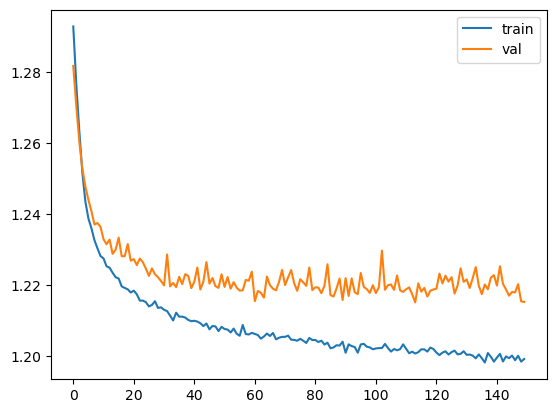

In [39]:
plt.plot(train_losses, label = 'train')
plt.plot(val_losses, label = 'val')
plt.legend()
plt.show()

In [50]:
batch_size = 50
file_path = Path("/kaggle/input/california-spatial-temporal-fire-dataset/numpy_california_spatialtemporal_dataset.npy")
numpy_array = np.load(file_path)[:,:,700:,:]
dataloader = temporal_dataloader(numpy_array, sequence_length, batch_size, radius = 2, train_or_test = False, pin_memory = False, num_workers=0)
f1, recall, precision, auprc, aucroc, accuracy, samples, loss, loss_samples = evaluate_model(ConvTranModel, dataloader, criterion, device)
del numpy_array
del dataloader

print(f'epoch #{epoch}:')
print(f'val_loss: {loss/loss_samples}!')
print(f'f1: {f1/samples}')
print(f'recall: {recall/samples}')
print(f'precision: {precision/samples}')
print(f'auprc: {auprc/samples}')
print(f'aucroc: {aucroc/samples}')
print(f'accuracy: {accuracy/samples}')

evaluating: 100%|██████████| 3706/3706 [00:25<00:00, 144.46it/s]

epoch #149:
val_loss: 0.038237448781728745!
f1: 0.18784984348956738
recall: 0.7280537490194094
precision: 0.11153632696336227
auprc: 0.11115251843764634
aucroc: 0.7813035331950172
accuracy: 0.8318445226105221


simple tran

In [52]:
TranModel = TransformerNet() #take their default vals
optimizer = RAdam(TranModel.parameters(), lr=config['lr'], weight_decay=0)
pos_weight = torch.tensor([4]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
#criterion = nn.CrossEntropyLoss()
#criterion = get_loss_module()
print(sum(p.numel() for p in TranModel.parameters()))

TranModel.to(device)

num_epochs = 50
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    
    batch_size = 50
    file_path = Path('/kaggle/input/california-spatial-temporal-fire-dataset/numpy_california_spatialtemporal_dataset.npy')
    train_numpy_array = np.load(file_path)[:,:,:700,:]
    train_dataloader = temporal_dataloader(train_numpy_array, sequence_length, batch_size, radius = 0, train_or_test = True, pin_memory = True, num_workers=0)
    loss, samples = train(TranModel, train_dataloader, optimizer, criterion, device, epoch)
    del train_numpy_array
    del train_dataloader
    #checkpoint_path = f'/kaggle/output/model_checkpoints/model_checkpoint_epoch_{epoch}.pt'
    #torch.save(ConvTranModel.state_dict(), checkpoint_path)
    train_losses.append(loss.item()/samples)
    
    batch_size = 50
    val_numpy_array = np.load(file_path)[:,:,700:,:]
    val_dataloader = temporal_dataloader(val_numpy_array, sequence_length, batch_size, radius = 0, train_or_test = True, pin_memory = True, num_workers=0)
    f1, recall, precision, auprc, aucroc, accuracy, samples, loss, loss_samples = evaluate_model(TranModel, val_dataloader, criterion, device)
    del val_numpy_array
    del val_dataloader
    
    val_losses.append(loss.item()/loss_samples)
    
    print(f'epoch #{epoch}:')
    print(f'train_loss: {train_losses[epoch]}; val_loss: {val_losses[epoch]}!')
    print(f'f1: {f1/samples}')
    print(f'recall: {recall/samples}')
    print(f'precision: {precision/samples}')
    print(f'auprc: {auprc/samples}')
    print(f'aucroc: {aucroc/samples}')
    print(f'accuracy: {accuracy/samples}')

4374275


evaluating: 100%|██████████| 124/124 [00:01<00:00, 62.29it/s]


epoch #0:
train_loss: 0.02531062804856325; val_loss: 0.02464246680289241!
f1: 0.5702337466806936
recall: 0.8716969597712299
precision: 0.42896446757702394
auprc: 0.41848326422093984
aucroc: 0.6459149476280053
accuracy: 0.5701313442516621


evaluating: 100%|██████████| 124/124 [00:01<00:00, 62.54it/s]


epoch #1:
train_loss: 0.024019848647995376; val_loss: 0.023280527001652205!
f1: 0.6086991840435426
recall: 0.8080185837028571
precision: 0.49572460667005813
auprc: 0.4676474078211867
aucroc: 0.6981525037742888
accuracy: 0.662017515407071


evaluating: 100%|██████████| 124/124 [00:01<00:00, 64.07it/s]


epoch #2:
train_loss: 0.023082586070198325; val_loss: 0.022934934821143536!
f1: 0.6187414653202425
recall: 0.8068707369669416
precision: 0.5102265189038883
auprc: 0.47903441125634316
aucroc: 0.7106541132374827
accuracy: 0.677152586346684


evaluating: 100%|██████████| 124/124 [00:01<00:00, 63.14it/s]


epoch #3:
train_loss: 0.022692503876999177; val_loss: 0.023027754378933486!
f1: 0.6105633575084711
recall: 0.8122670537778461
precision: 0.49551250312929523
auprc: 0.4687064722561779
aucroc: 0.7003220471005642
accuracy: 0.6648289281660451


evaluating: 100%|██████████| 124/124 [00:02<00:00, 61.91it/s]


epoch #4:
train_loss: 0.02253534623837194; val_loss: 0.022910192176320284!
f1: 0.6202387116860593
recall: 0.7749118225748874
precision: 0.5253649431907105
auprc: 0.48635942584995834
aucroc: 0.711308405686502
accuracy: 0.6893140911302091


evaluating: 100%|██████████| 124/124 [00:01<00:00, 63.52it/s]


epoch #5:
train_loss: 0.022472900061713853; val_loss: 0.02296383165129972!
f1: 0.6172191636571368
recall: 0.7871080154521332
precision: 0.5145750666531472
auprc: 0.47823191422141453
aucroc: 0.7081918778589038
accuracy: 0.681641258514434


evaluating: 100%|██████████| 124/124 [00:01<00:00, 64.06it/s]


epoch #6:
train_loss: 0.0223738377165551; val_loss: 0.023120972293305092!
f1: 0.6044537406979765
recall: 0.8088376413784404
precision: 0.49073245040152325
auprc: 0.46325832135686346
aucroc: 0.6949979206634215
accuracy: 0.6570455651045889


evaluating: 100%|██████████| 124/124 [00:01<00:00, 62.50it/s]


epoch #7:
train_loss: 0.022376537001795753; val_loss: 0.023034685780566028!
f1: 0.6131815637450271
recall: 0.7388935264272746
precision: 0.533966246745799
auprc: 0.485035137236046
aucroc: 0.7077922496011583
accuracy: 0.6961738002594033


evaluating: 100%|██████████| 124/124 [00:01<00:00, 63.08it/s]


epoch #8:
train_loss: 0.02235224570915704; val_loss: 0.023039133786845918!
f1: 0.6121701163997529
recall: 0.7953551434531133
precision: 0.5052143656829958
auprc: 0.4730522513107453
aucroc: 0.702410168912669
accuracy: 0.6707198443579766


evaluating: 100%|██████████| 124/124 [00:01<00:00, 62.40it/s]


epoch #9:
train_loss: 0.02233500366242567; val_loss: 0.02310040643397627!
f1: 0.6036548495687982
recall: 0.760138893362618
precision: 0.5068702684338551
auprc: 0.4697373999459499
aucroc: 0.6957483704141596
accuracy: 0.6763942931258107


evaluating: 100%|██████████| 124/124 [00:01<00:00, 63.35it/s]


epoch #10:
train_loss: 0.022356481816553024; val_loss: 0.023061228703114865!
f1: 0.6108927630481227
recall: 0.8186108574102152
precision: 0.4929389216608071
auprc: 0.46596298777825884
aucroc: 0.6983577078978832
accuracy: 0.6578563320901573


evaluating: 100%|██████████| 124/124 [00:01<00:00, 64.36it/s]


epoch #11:
train_loss: 0.022163608553792815; val_loss: 0.02292208541691999!
f1: 0.6182342834886018
recall: 0.7911179160376818
precision: 0.5154153433820748
auprc: 0.48058496363609177
aucroc: 0.7085374752851354
accuracy: 0.6804474708171206


evaluating: 100%|██████████| 124/124 [00:01<00:00, 64.47it/s]


epoch #12:
train_loss: 0.022243765823976254; val_loss: 0.023034424995977836!
f1: 0.6108192310708863
recall: 0.7840336663438102
precision: 0.5090645228224169
auprc: 0.47399634210172764
aucroc: 0.7034138468816261
accuracy: 0.6755310523755472


evaluating: 100%|██████████| 124/124 [00:01<00:00, 62.87it/s]


epoch #13:
train_loss: 0.022258914517152926; val_loss: 0.023021227964012847!
f1: 0.6112156902723336
recall: 0.7224062723732949
precision: 0.5391111057417274
auprc: 0.4856327433468548
aucroc: 0.7069597014256586
accuracy: 0.7020103761348897


evaluating: 100%|██████████| 124/124 [00:01<00:00, 64.25it/s]


epoch #14:
train_loss: 0.022246111081087427; val_loss: 0.022976399086483412!
f1: 0.6117683870082248
recall: 0.8075586473165182
precision: 0.5011343536622457
auprc: 0.47158877604518495
aucroc: 0.7029186649047204
accuracy: 0.666828793774319


evaluating: 100%|██████████| 124/124 [00:02<00:00, 58.57it/s]


epoch #15:
train_loss: 0.022233070913578318; val_loss: 0.02299090334722813!
f1: 0.6113902516703342
recall: 0.7682855302844797
precision: 0.5157620462217207
auprc: 0.47652517097495045
aucroc: 0.7051274133964847
accuracy: 0.6845006485084306


evaluating: 100%|██████████| 124/124 [00:01<00:00, 64.66it/s]


epoch #16:
train_loss: 0.022199487713338698; val_loss: 0.022996044205328005!
f1: 0.611235616852984
recall: 0.7511391826584517
precision: 0.5239934171559735
auprc: 0.48034515771482783
aucroc: 0.7053178453880181
accuracy: 0.6902870115128912


evaluating: 100%|██████████| 124/124 [00:01<00:00, 63.96it/s]


epoch #17:
train_loss: 0.022159890716391434; val_loss: 0.022945351474614125!
f1: 0.615683183269805
recall: 0.8092639503335314
precision: 0.5041574828573571
auprc: 0.4747622470997418
aucroc: 0.7045785852621286
accuracy: 0.6705042970650235


evaluating: 100%|██████████| 124/124 [00:01<00:00, 64.46it/s]


epoch #18:
train_loss: 0.022257433739186865; val_loss: 0.022943549290748915!
f1: 0.6154597226138511
recall: 0.7750235673410447
precision: 0.5182341421845159
auprc: 0.48050597981013665
aucroc: 0.7072740712341532
accuracy: 0.6850470321115796


evaluating: 100%|██████████| 124/124 [00:01<00:00, 65.36it/s]


epoch #19:
train_loss: 0.022178751511629884; val_loss: 0.02293930350574538!
f1: 0.6121982120165103
recall: 0.7874419419202326
precision: 0.5083514280026787
auprc: 0.474355473163322
aucroc: 0.7036041056966551
accuracy: 0.6759079118028535


evaluating: 100%|██████████| 124/124 [00:01<00:00, 65.16it/s]


epoch #20:
train_loss: 0.022116567760359983; val_loss: 0.022956944656495802!
f1: 0.6181674291851326
recall: 0.7170699221048374
precision: 0.5532688283086178
auprc: 0.4948634258392148
aucroc: 0.7139807948209568
accuracy: 0.7126175802789491


evaluating: 100%|██████████| 124/124 [00:01<00:00, 62.88it/s]


epoch #21:
train_loss: 0.022121839417560272; val_loss: 0.022988499119573316!
f1: 0.6125945957657705
recall: 0.7541329321953143
precision: 0.5246730484836482
auprc: 0.48242520022602386
aucroc: 0.7062760428409265
accuracy: 0.6905611417450536


evaluating: 100%|██████████| 124/124 [00:02<00:00, 61.32it/s]


epoch #22:
train_loss: 0.022119116271662704; val_loss: 0.023046301465492997!
f1: 0.6090546647589928
recall: 0.7865244443009972
precision: 0.5034459586054397
auprc: 0.4699740802256228
aucroc: 0.6995294097296862
accuracy: 0.6709907572563645


evaluating: 100%|██████████| 124/124 [00:01<00:00, 63.69it/s]


epoch #23:
train_loss: 0.022097435335562236; val_loss: 0.023037695954349745!
f1: 0.6155215285066794
recall: 0.6993454096177928
precision: 0.5598229020186396
auprc: 0.4959136784982616
aucroc: 0.7118891217458865
accuracy: 0.7151898734177216


evaluating: 100%|██████████| 124/124 [00:02<00:00, 52.72it/s]


epoch #24:
train_loss: 0.02211026841957392; val_loss: 0.02299055453249762!
f1: 0.6123383916356364
recall: 0.8056849422380752
precision: 0.5013863803850201
auprc: 0.47182762771023345
aucroc: 0.7017960184935516
accuracy: 0.6663424124513618


evaluating: 100%|██████████| 124/124 [00:01<00:00, 63.29it/s]


epoch #25:
train_loss: 0.02218045377442241; val_loss: 0.023064462566793266!
f1: 0.6124675492535337
recall: 0.6982302554527083
precision: 0.555996748975408
auprc: 0.4943959843167161
aucroc: 0.7103397023300365
accuracy: 0.7137992540943733


evaluating: 100%|██████████| 124/124 [00:01<00:00, 62.47it/s]


epoch #26:
train_loss: 0.022064069815236016; val_loss: 0.02298835666558142!
f1: 0.6122081174436252
recall: 0.7688605159856736
precision: 0.5167680917016655
auprc: 0.4792281494886413
aucroc: 0.7058153441242816
accuracy: 0.6841251824225717


evaluating: 100%|██████████| 124/124 [00:01<00:00, 63.81it/s]


epoch #27:
train_loss: 0.022142591041087782; val_loss: 0.022853289041755768!
f1: 0.6206008833358908
recall: 0.7597970608035161
precision: 0.5328090056251363
auprc: 0.48904212151375415
aucroc: 0.7135730224563961
accuracy: 0.6988811415599157


evaluating: 100%|██████████| 124/124 [00:01<00:00, 63.66it/s]


epoch #28:
train_loss: 0.02206544727341847; val_loss: 0.022799245732922187!
f1: 0.6235387914078843
recall: 0.78074521907333
precision: 0.5285725430412938
auprc: 0.4888653173161895
aucroc: 0.7165547119906515
accuracy: 0.6937418936446174


evaluating: 100%|██████████| 124/124 [00:01<00:00, 63.26it/s]


epoch #29:
train_loss: 0.022018288711103482; val_loss: 0.02289034362664307!
f1: 0.6199279471243865
recall: 0.7160017485334135
precision: 0.5569058543162482
auprc: 0.4984870405988008
aucroc: 0.7151695293208611
accuracy: 0.7137992540943733


evaluating: 100%|██████████| 124/124 [00:01<00:00, 64.14it/s]


epoch #30:
train_loss: 0.02203226657787967; val_loss: 0.022972012926786946!
f1: 0.6206620237204638
recall: 0.7406080462306985
precision: 0.5424533577827946
auprc: 0.4933318794733983
aucroc: 0.712787200671296
accuracy: 0.7028210116731517


evaluating: 100%|██████████| 124/124 [00:02<00:00, 60.69it/s]


epoch #31:
train_loss: 0.02208625147822929; val_loss: 0.022920396043045393!
f1: 0.6182885637824695
recall: 0.7160218073352793
precision: 0.5526972438885703
auprc: 0.49562076666131283
aucroc: 0.713677888447125
accuracy: 0.7133127939030323


evaluating: 100%|██████████| 124/124 [00:01<00:00, 64.29it/s]


epoch #32:
train_loss: 0.022039993227621547; val_loss: 0.02281794813974977!
f1: 0.6228164871217395
recall: 0.7602425124377915
precision: 0.53645541193014
auprc: 0.49130594646504233
aucroc: 0.7151246437075877
accuracy: 0.7000648508430609


evaluating: 100%|██████████| 124/124 [00:01<00:00, 62.55it/s]


epoch #33:
train_loss: 0.02208392886204205; val_loss: 0.022997976605888704!
f1: 0.6143681376021972
recall: 0.7137966471901777
precision: 0.5484235151427124
auprc: 0.4907591873968343
aucroc: 0.7094682107612283
accuracy: 0.7082860385925085


evaluating: 100%|██████████| 124/124 [00:01<00:00, 64.54it/s]


epoch #34:
train_loss: 0.021988897079482005; val_loss: 0.02298047601326276!
f1: 0.6141519257957335
recall: 0.7630273092607202
precision: 0.5224256328028237
auprc: 0.48106000371332724
aucroc: 0.7068668806746179
accuracy: 0.6883916990920882


evaluating: 100%|██████████| 124/124 [00:01<00:00, 62.12it/s]


epoch #35:
train_loss: 0.021977002122658316; val_loss: 0.023071818469254116!
f1: 0.608223527369471
recall: 0.7111053115041976
precision: 0.5416102044387188
auprc: 0.4872031547496259
aucroc: 0.7059807977033673
accuracy: 0.7044422827496758


evaluating: 100%|██████████| 124/124 [00:01<00:00, 64.52it/s]


epoch #36:
train_loss: 0.022004756959121224; val_loss: 0.022869419340339!
f1: 0.620506680115401
recall: 0.7532562710562956
precision: 0.5371140504910615
auprc: 0.48959528073502606
aucroc: 0.7147201494518226
accuracy: 0.7011997405966277


evaluating: 100%|██████████| 124/124 [00:01<00:00, 64.65it/s]


epoch #37:
train_loss: 0.022033003467892515; val_loss: 0.022984085379871413!
f1: 0.6094505620083982
recall: 0.7660661582229421
precision: 0.5136166291637365
auprc: 0.4756615059871162
aucroc: 0.7018127344242019
accuracy: 0.6819066147859922


evaluating: 100%|██████████| 124/124 [00:01<00:00, 63.72it/s]


epoch #38:
train_loss: 0.022003831650421492; val_loss: 0.023138742460817152!
f1: 0.6047065658691507
recall: 0.7020269378903173
precision: 0.5433885402148999
auprc: 0.4847685810312467
aucroc: 0.7050930220915562
accuracy: 0.7053672774444625


evaluating: 100%|██████████| 124/124 [00:01<00:00, 62.31it/s]


epoch #39:
train_loss: 0.021966031347595505; val_loss: 0.023078958038844643!
f1: 0.612793193010252
recall: 0.6890305901052003
precision: 0.561416472843567
auprc: 0.495100540189633
aucroc: 0.7089830983392683
accuracy: 0.7153047989623865


evaluating: 100%|██████████| 124/124 [00:02<00:00, 56.62it/s]


epoch #40:
train_loss: 0.021894870190112128; val_loss: 0.023004616617653767!
f1: 0.6160817807605519
recall: 0.7341939945087865
precision: 0.5400361118889181
auprc: 0.48980233062316925
aucroc: 0.7095787605540734
accuracy: 0.7004541031462861


evaluating: 100%|██████████| 124/124 [00:01<00:00, 64.47it/s]


epoch #41:
train_loss: 0.021992259670696183; val_loss: 0.022827643290396465!
f1: 0.6218563085244598
recall: 0.7743616585032771
precision: 0.5272230971230425
auprc: 0.48693726954541533
aucroc: 0.7129660590823866
accuracy: 0.69288146586671


evaluating: 100%|██████████| 124/124 [00:01<00:00, 62.42it/s]


epoch #42:
train_loss: 0.021911519874585405; val_loss: 0.022841717018691483!
f1: 0.6240126917502989
recall: 0.7429123449411472
precision: 0.5453553200338184
auprc: 0.49510075614321225
aucroc: 0.7163833441097609
accuracy: 0.7080090791180286


evaluating: 100%|██████████| 124/124 [00:01<00:00, 64.40it/s]


epoch #43:
train_loss: 0.02197668245758142; val_loss: 0.022909872996202063!
f1: 0.6142464336865466
recall: 0.7624412660932424
precision: 0.5227575849511036
auprc: 0.48152725435961774
aucroc: 0.7070518460751168
accuracy: 0.6893140911302091


evaluating: 100%|██████████| 124/124 [00:01<00:00, 63.02it/s]


epoch #44:
train_loss: 0.021969248010942195; val_loss: 0.0232050929088073!
f1: 0.6027008785592317
recall: 0.676382975589524
precision: 0.5532951086977071
auprc: 0.48619999237954303
aucroc: 0.7001346538587533
accuracy: 0.7083333333333334


evaluating: 100%|██████████| 124/124 [00:01<00:00, 63.74it/s]


epoch #45:
train_loss: 0.021973239781263764; val_loss: 0.023128510758817254!
f1: 0.6030093246202008
recall: 0.6750137084861959
precision: 0.5546146388189573
auprc: 0.4883829505415702
aucroc: 0.7029357278409766
accuracy: 0.7137528381446643


evaluating: 100%|██████████| 124/124 [00:02<00:00, 61.01it/s]


epoch #46:
train_loss: 0.02191575936526423; val_loss: 0.023143324108043352!
f1: 0.6030746154023854
recall: 0.6960543974015833
precision: 0.5419376945775068
auprc: 0.4844217972854692
aucroc: 0.7001859575619951
accuracy: 0.7027246188777165


evaluating: 100%|██████████| 124/124 [00:01<00:00, 63.92it/s]


epoch #47:
train_loss: 0.021866754861102115; val_loss: 0.023063341724982773!
f1: 0.6080416674250272
recall: 0.71635412411917
precision: 0.5370144437800924
auprc: 0.4845380942379263
aucroc: 0.7049825107201072
accuracy: 0.7011512891195071


evaluating: 100%|██████████| 124/124 [00:02<00:00, 60.40it/s]


epoch #48:
train_loss: 0.021953879486509398; val_loss: 0.02304653652061882!
f1: 0.6107034441058578
recall: 0.6993560842451305
precision: 0.552226402123129
auprc: 0.49186915814244486
aucroc: 0.707788302724236
accuracy: 0.7113669531376682


evaluating: 100%|██████████| 124/124 [00:02<00:00, 52.24it/s]


epoch #49:
train_loss: 0.02188964027712776; val_loss: 0.023117609856154214!
f1: 0.6048925467730613
recall: 0.7204930239458434
precision: 0.5293482535851038
auprc: 0.4778968962512016
aucroc: 0.7009928499357982
accuracy: 0.6952643529030166


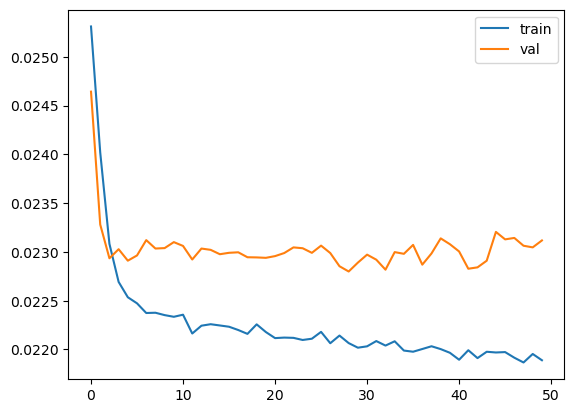

In [53]:
plt.plot(train_losses, label = 'train')
plt.plot(val_losses, label = 'val')
plt.legend()
plt.show()

In [54]:
batch_size = 50
file_path = Path("/kaggle/input/california-spatial-temporal-fire-dataset/numpy_california_spatialtemporal_dataset.npy")
numpy_array = np.load(file_path)[:,:,700:,:]
dataloader = temporal_dataloader(numpy_array, sequence_length, batch_size, radius = 2, train_or_test = False, pin_memory = False, num_workers=0)
f1, recall, precision, auprc, aucroc, accuracy, samples, loss, loss_samples = evaluate_model(TranModel, dataloader, criterion, device)
del numpy_array
del dataloader

print(f'epoch #{epoch}:')
print(f'val_loss: {loss/loss_samples}!')
print(f'f1: {f1/samples}')
print(f'recall: {recall/samples}')
print(f'precision: {precision/samples}')
print(f'auprc: {auprc/samples}')
print(f'aucroc: {aucroc/samples}')
print(f'accuracy: {accuracy/samples}')

evaluating: 100%|██████████| 3706/3706 [00:40<00:00, 92.29it/s] 

epoch #49:
val_loss: 0.01781635545194149!
f1: 0.10801960286189932
recall: 0.7176704029458967
precision: 0.059333273688569645
auprc: 0.06307741104245385
aucroc: 0.7061337315614951
accuracy: 0.6953211499944018
